# Assignment 2: White Blood Cell Segmentation — K-Means vs Fuzzy C-Means
**Task:** Segment WBC nucleus & cytoplasm  
**Methods:** K-Means vs Fuzzy C-Means  
**Compare:** Boundary accuracy  
**Learning:** Hard vs soft clustering

In [5]:
!pip install scikit-fuzzy -q

In [6]:
import os, glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import skfuzzy as fuzz
from skimage.segmentation import find_boundaries
from skimage.filters import sobel
import warnings
warnings.filterwarnings('ignore')

# Load one image from Train folder
base   = '/kaggle/input/datasets/masoudnickparvar/white-blood-cells-dataset'
images = glob.glob(os.path.join(base, 'Train', '**', '*.jpg'), recursive=True)
print(f'Found {len(images)} training images')

img_rgb = cv2.cvtColor(
    cv2.resize(cv2.imread(images[0]), (256, 256)),
    cv2.COLOR_BGR2RGB
)
print(f'Image: {os.path.basename(images[0])}')

Found 10175 training images
Image: 95-8-3-1_499_1.jpg


In [7]:
# Convert to LAB colour space — better separation of biological stains
img_lab  = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2LAB).astype(np.float64)
features = (img_lab.reshape(-1, 3)) / 255.0   # (N_pixels, 3)
H, W     = img_rgb.shape[:2]

def assign_semantic(label_map):
    """Sort clusters by L-channel brightness: bright=background, mid=cytoplasm, dark=nucleus"""
    L      = img_lab[:, :, 0]
    order  = np.argsort([L[label_map == k].mean() for k in range(3)])[::-1]
    out    = np.zeros_like(label_map)
    for new_lbl, old_lbl in enumerate(order):
        out[label_map == old_lbl] = new_lbl   # 0=bg, 1=cytoplasm, 2=nucleus
    return out

In [8]:
# K-Means — hard clustering (each pixel gets exactly one label)
km_raw = KMeans(n_clusters=3, random_state=42, n_init=10).fit_predict(features)
km_seg = assign_semantic(km_raw.reshape(H, W))
print('K-Means done')

K-Means done


In [9]:
# Fuzzy C-Means — soft clustering (each pixel gets a membership degree per cluster)
# skfuzzy expects shape (n_features, n_samples)
cntr, u, *_ = fuzz.cluster.cmeans(
    features.T, c=3, m=2.0, error=0.005, maxiter=150, seed=42
)
# Hard decision: assign to cluster with highest membership
fcm_raw = np.argmax(u, axis=0).reshape(H, W)
fcm_seg = assign_semantic(fcm_raw)
print('Fuzzy C-Means done')

Fuzzy C-Means done


In [10]:
# Boundary accuracy: mean image gradient at detected boundary pixels
# Higher = boundaries align with real edges = better accuracy
gray      = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY).astype(float) / 255.0
gradient  = sobel(gray)

km_bounds  = find_boundaries(km_seg,  mode='inner')
fcm_bounds = find_boundaries(fcm_seg, mode='inner')

km_score  = gradient[km_bounds].mean()  if km_bounds.any()  else 0
fcm_score = gradient[fcm_bounds].mean() if fcm_bounds.any() else 0

print(f'Boundary Accuracy (mean gradient at boundary):')
print(f'  K-Means : {km_score:.4f}')
print(f'  FCM     : {fcm_score:.4f}')
print(f'  Winner  : {"K-Means" if km_score > fcm_score else "FCM"}')

Boundary Accuracy (mean gradient at boundary):
  K-Means : 0.0664
  FCM     : 0.0452
  Winner  : K-Means


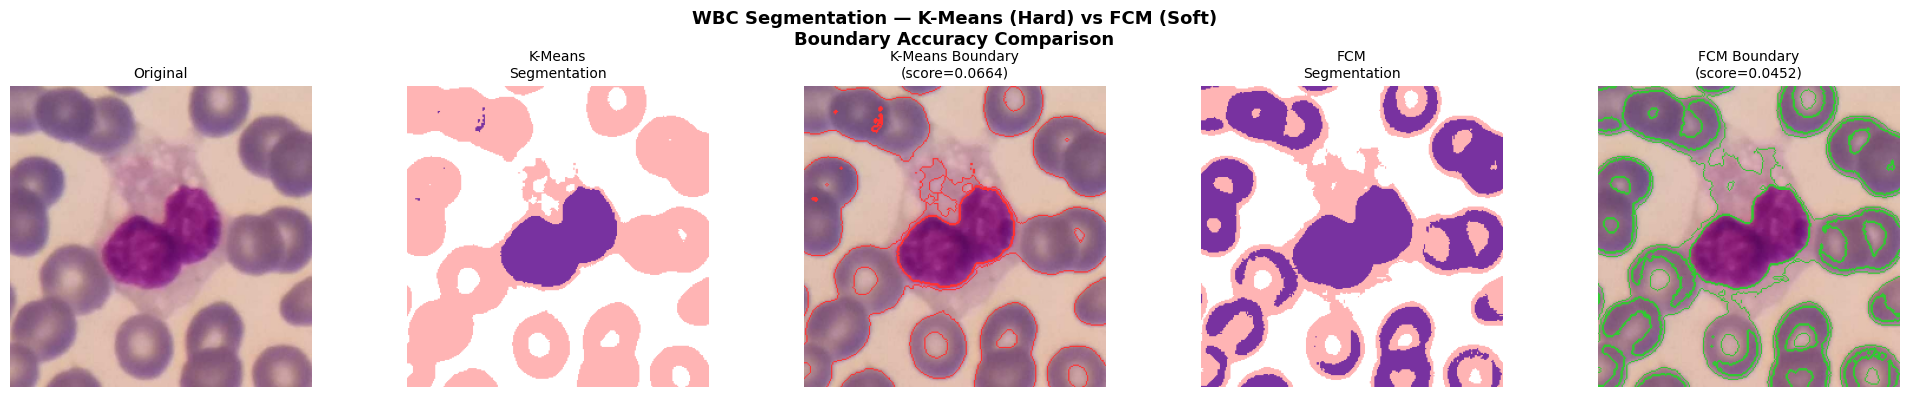

Saved: assignment2_output.png


In [11]:
# Visualisation
def colorize(seg):
    """background=white, cytoplasm=pink, nucleus=purple"""
    out = np.zeros((*seg.shape, 3), dtype=np.uint8)
    out[seg == 0] = [255, 255, 255]   # background
    out[seg == 1] = [255, 180, 180]   # cytoplasm
    out[seg == 2] = [120,  50, 160]   # nucleus
    return out

def draw_boundary(img, bounds, color):
    out = img.copy()
    out[bounds] = color
    return out

fig, axes = plt.subplots(1, 5, figsize=(20, 4))
titles = ['Original', 'K-Means\nSegmentation',
          f'K-Means Boundary\n(score={km_score:.4f})',
          'FCM\nSegmentation',
          f'FCM Boundary\n(score={fcm_score:.4f})']
images_show = [
    img_rgb,
    colorize(km_seg),
    draw_boundary(img_rgb, km_bounds, [255, 50, 50]),
    colorize(fcm_seg),
    draw_boundary(img_rgb, fcm_bounds, [50, 200, 50])
]
for ax, img_s, title in zip(axes, images_show, titles):
    ax.imshow(img_s)
    ax.set_title(title, fontsize=10)
    ax.axis('off')

plt.suptitle('WBC Segmentation — K-Means (Hard) vs FCM (Soft)\nBoundary Accuracy Comparison',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('assignment2_output.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: assignment2_output.png')

In [12]:
# Hard vs Soft clustering — key learning
print('=== HARD vs SOFT CLUSTERING ===')
print()
print('K-Means (Hard clustering):')
print('  Every pixel is assigned to EXACTLY ONE cluster.')
print('  A boundary pixel is forced to be fully cytoplasm OR fully nucleus.')
print()
print('Fuzzy C-Means (Soft clustering):')
print('  Every pixel gets a MEMBERSHIP DEGREE for each cluster (values 0-1).')
print('  A boundary pixel can be, e.g., 60% cytoplasm + 40% nucleus.')
print('  This reflects real staining gradients at the nucleus-cytoplasm boundary.')
print()
print(f'Boundary Accuracy scores:')
print(f'  K-Means : {km_score:.4f}')
print(f'  FCM     : {fcm_score:.4f}')

=== HARD vs SOFT CLUSTERING ===

K-Means (Hard clustering):
  Every pixel is assigned to EXACTLY ONE cluster.
  A boundary pixel is forced to be fully cytoplasm OR fully nucleus.

Fuzzy C-Means (Soft clustering):
  Every pixel gets a MEMBERSHIP DEGREE for each cluster (values 0-1).
  A boundary pixel can be, e.g., 60% cytoplasm + 40% nucleus.
  This reflects real staining gradients at the nucleus-cytoplasm boundary.

Boundary Accuracy scores:
  K-Means : 0.0664
  FCM     : 0.0452
